## Описание проекта сервиса repetit.ru

Сервис Repetit.ru работает с большим количеством заявок от клиентов с данными о предмете, желаемой стоимости, возрасте ученика, целью занятий и тд. К сожалению, 7 из 8 не доходят до оплаты, при этом обработка заявки консультантом увеличивает конверсию в оплату на 30%.\
Проблема в том, что консультантов не хватает на все заявки и получается, что чем больше заявок — тем меньше конверсия из заявки в оплату и консультанты тратят время на бесперспективные заявки.\
\
\
**Задачей данного проекта является:** \
Разработать модель, которая по имеющейся информации о клиенте и заявке будет предсказывать вероятность оплаты заявки клиентом. Заказчик хочет понять, какие заявки будут оплачены, а какие нет, чтобы одни обрабатывать вручную консультантами, а другие нет. Оценка качества модели будет производиться с использованием precision и ROC-AUC.\
\
Задачей является задача бинарной классификации заявок от клиентов.

### 1. Открываю файлы с данными

In [1]:
pip -q install phik

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMClassifier


In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df_orders = pd.read_feather(r'C:\Users\2011\Desktop\Data Science\2024-Repetit.ru\data/orders.feather')
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        

In [5]:
display(df_orders.head(10))

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.0,16,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.0,16,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,None,None,1
5,2294059,2022-11-01 00:20:30.610,3.0,None,0,60,None,464.0,None,None,NaN,16,Тестовая группа : SplitTestB,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,16,NaN,1024441,5.0,NaN,None,None,1
6,2294060,2022-11-01 00:20:43.873,3.0,None,0,60,None,464.0,None,None,NaN,7,Тестовая группа : SplitTestB\n01.11.2022 09:07...,NaN,0,0,None,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,16,2294059.0,1024441,7.0,NaN,None,None,1
7,2294061,2022-11-01 00:20:51.263,3.0,None,0,60,None,464.0,None,None,NaN,7,Тестовая группа : SplitTestB\n01.11.2022 09:07...,NaN,0,0,None,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,16,2294059.0,1024441,7.0,NaN,None,None,1
8,2294062,2022-11-01 00:20:59.183,3.0,None,0,60,None,464.0,None,None,NaN,7,Тестовая группа : SplitTestB\n01.11.2022 09:07...,NaN,0,0,None,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,16,2294059.0,1024441,7.0,NaN,None,None,1
9,2294063,2022-11-01 00:25:17.180,9.0,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 09:14 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,8,2294052.0,1024437,7.0,NaN,None,None,1


In [6]:
df_prefered_teachers = pd.read_feather(r'C:\Users\2011\Desktop\Data Science\2024-Repetit.ru\data/prefered_teachers_order_id.feather')
df_prefered_teachers.info()
display (df_prefered_teachers.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135198 entries, 0 to 1135197
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   order_id    1135198 non-null  int32
 1   teacher_id  1135198 non-null  int32
dtypes: int32(2)
memory usage: 8.7 MB


,order_id,teacher_id
0,2469225,19663
1,2470455,19663
2,2480251,19663
3,2481259,19663
4,2483171,19663
5,2521084,19663
6,2521124,19663
7,2522705,19663
8,2558804,19663
9,2558840,19663


In [7]:
df_suitable_teachers = pd.read_feather(r'C:\Users\2011\Desktop\Data Science\2024-Repetit.ru\data/suitable_teachers.feather')
df_suitable_teachers.info()
display (df_suitable_teachers.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 5 columns):
 #   Column              Dtype   
---  ------              -----   
 0   teacher_id          int32   
 1   order_id            int32   
 2   contact_result      category
 3   enable_auto_assign  int8    
 4   enable_assign       int8    
dtypes: category(1), int32(2), int8(2)
memory usage: 232.3 MB


,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
0,82583,1742711,Репетитор согласился,1,1
1,125057,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
2,231211,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
3,128773,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
4,63019,1742713,Репетитор согласился,0,1
5,238654,1742714,",",0,0
6,155227,1742714,",",0,0
7,5244,1742714,",",0,0
8,145485,1742714,",",0,0
9,163724,1742714,",",0,0


In [8]:
df_teachers = pd.read_feather(r'C:\Users\2011\Desktop\Data Science\2024-Repetit.ru\data/teachers_info.feather')
df_teachers.info()
display (df_teachers.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id                   307972 non-null  int8    
 13 

,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
0,33,2023-11-07 14:20:28.323,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,45,0,0,0,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,/teachers/33/photo/photo_small.jpg,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,1,15,5,Швачко М.Н. 15.01.2018 14:59 - 33\r\nАникеева ...,2016-02-12 21:06:51.000,2022-10-24 16:48:38.410,1.0,0,4.679688,1,NaN,1,500,1,NaN,0,1,0,1138.0,237.5,NaN,1,0,492.0,1,NaN,NaN,4.500000,1138.0,6,2022-05-16 18:44:59.993,0,3702.0,2023-11-06 14:20:15.173
1,46,2023-01-19 17:36:42.233,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,63,0,1,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,/teachers/46/photo/photo_small.webp,NaN,1,0,4,-3,NaN,2014-08-12 00:00:00.000,NaN,1.0,0,0.000000,1,NaN,3,0,0,NaN,0,1,1,25.0,0.0,NaN,1,1,0.0,1,NaN,NaN,4.300781,25.0,0,2017-01-01 00:00:00.000,1,NaN,NaN
2,51,2023-05-25 09:04:45.243,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,68,0,0,0,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,/teachers/51/photo/photo_small.webp,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,0,16,6,NaN,2016-04-06 16:08:24.000,2022-09-26 09:43:56.123,1.0,0,6.000000,1,NaN,2,0,1,Только удаленные занятия по Skype.,0,1,0,300.0,0.0,NaN,1,1,2182.0,3,0.0,NaN,4.300781,300.0,0,2017-01-01 00:00:00.000,0,NaN,NaN
3,52,2023-01-19 10:39:20.767,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,69,0,0,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,/teachers/52/photo/photo_small.webp,NaN,1,1,16,6,NaN,2014-08-12 00:00:00.000,2020-04-03 15:53:50.867,0.0,0,11.289062,1,2019-12-31 00:00:00.000,2,0,1,NaN,0,1,1,135.0,0.0,NaN,1,1,2084.0,1,0.0,NaN,5.000000,135.0,2,2020-04-01 01:07:44.157,1,NaN,NaN
4,54,2023-01-19 16:28:36.517,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,70,0,0,1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,/teachers/54/photo/photo_small.webp,"4 года репетиторской деятельности, \r\nподгото...",1,0,4,-3,"21,01

## Объединяю таблицы df_suitable_teachers + df_teachers по столбцу id

Переименовываю столбец id в таблице df_teachers, чтобы можно было его объединить с таблицей 'df_orders_suitable_teachers'

In [9]:
df_teachers = df_teachers.rename(columns={'id':'teacher_id'})

Объединяю таблицы

In [10]:
df_merge_teachers = df_suitable_teachers.merge(df_teachers, on='teacher_id', how='left')

In [11]:
df_merge_teachers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20271186 entries, 0 to 20271185
Data columns (total 84 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   teacher_id                  int32   
 1   order_id                    int32   
 2   contact_result              category
 3   enable_auto_assign          int8    
 4   enable_assign               int8    
 5   date_update                 category
 6   reg_date                    category
 7   birth_date                  category
 8   teaching_start_date         category
 9   user_id                     float64 
 10  is_email_confirmed          float64 
 11  is_home_lessons             float64 
 12  is_external_lessons         float64 
 13  external_comments           category
 14  lesson_duration             float64 
 15  lesson_cost                 float64 
 16  status_id                   float64 
 17  status_relevant_date        category
 18  status_school_id            float16 
 19

In [12]:
display (df_merge_teachers.head(5))

,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
0,82583,1742711,Репетитор согласился,1,1,2023-01-19 10:27:48.900,2015-02-16 14:04:03.000,1981-02-02 00:00:00.000,2000-09-01 00:00:00.000,83886.0,0.0,1.0,0.0,NaN,45.0,600.0,3.0,NaN,4028.0,NaN,0.0,5.0,7.0,[p]Лауреат всероссийских и международных конку...,1.0,NaN,45.0,600.0,3.0,NaN,4028.0,NaN,0.0,5.0,7.0,[p]Лауреат всероссийских и международных конку...,1.0,NaN,45.0,600.0,3.0,NaN,4028.0,NaN,0.0,5.0,7.0,/teachers/82583/photo/photo_small.webp,[p]Лауреат всероссийских и международных конку...,1.0,1.0,15.0,5.0,NaN,2014-08-12 00:00:00.000,2019-11-01 11:36:18.830,NaN,0.0,0.0,12.0,NaN,1.0,0.0,0.0,NaN,1.0,1.0,1.0,150.0,0.00,NaN,1.0,1.0,3180.0,0.0,0.0,NaN,4.300781,150.0,0.0,2017-01-01 00:00:00.000,1.0,7136.0,NaN
1,125057,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0,2023-03-06 09:26:48.290,2017-08-20 14:49:27.000,1997-04-09 00:00:00.000,2015-09-01 00:00:00.000,264033.0,0.0,0.0,1.0,Ближайший район: м. Царицыно. Выезд: Восточное...,60.0,1000.0,1.0,2022-06-01 00:00:00.000,NaN,NaN,0.0,5.0,7.0,NaN,1.0,Ближайший район: м. Царицыно. Выезд: Восточное...,60.0,1000.0,1.0,2022-06-01 00:00:00.000,NaN,NaN,0.0,5.0,7.0,NaN,1.0,Ближайший район: м. Царицыно. Выезд: Восточное...,60.0,1000.0,1.0,2022-06-01 00:00:00.000,NaN,NaN,0.0,5.0,7.0,/teachers/125057/photo/photo_small.webp,NaN,1.0,1.0,15.0,5.0,NaN,2017-10-01 20:39:02.000,2020-09-03 10:40:32.667,NaN,0.0,0.0,1.0,NaN,1.0,0.0,0.0,NaN,1.0,1.0,1.0,330.0,0.00,NaN,1.0,1.0,2232.0,3.0,0.0,NaN,4.300781,330.0,0.0,2017-10-01 20:31:58.000,1.0,NaN,NaN
2,231211,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0,2023-01-18 23:26:36.367,2021-05-05 13:53:21.797,2002-09-13 00:00:00.000,2020-09-01 00:00:00.000,800217.0,0.0,0.0,1.0,Ближайший район: м. Царицыно.,60.0,600.0,1.0,2026-06-01 00:00:00.000,NaN,NaN,1.0,5.0,7.0,NaN,1.0,Ближайший район: м. Царицыно.,60.0,600.0,1.0,2026-06-01 00:00:00.000,NaN,NaN,1.0,5.0,7.0,NaN,1.0,Ближайший район: м. Царицыно.,60.0,600.0,1.0,2026-06-01 00:00:00.000,NaN,NaN,1.0,5.0,7.0,/teachers/231211/photo/photo_small.webp,NaN,1.0,1.0,15.0,5.0,Дорошенко Е.В.\tДата создания\t22.10.2021 10:3...,2021-05-05 13:53:21.797,2021-11-30 19:49:34.977,NaN,0.0,0.0,1.0,NaN,1.0,0.0,0.0,NaN,1.0,1.0,1.0,200.0,0.00,NaN,0.0,0.0,886.0,3.0,NaN,NaN,4.300781,200.0,0.0,2021-05-05 13:53:21.797,1.0,NaN,NaN
3,128773,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0,2023-01-19 01:27:52.217,2017-09-17 18:35:35.000,1995-08-24 00:00:00.000,2015-09-01 00:00:00.000,279153.0,0.0,0.0,1.0,Ближайший район: м. Царицыно. Выезд: в предела...,60.0,700.0,5.0,NaN,NaN,NaN,0.0,5.0,7.0,NaN,1.0,Ближайший район: м. Царицыно. Выезд: в предела...,60.0,700.0,5.0,NaN,NaN,NaN,0.0,5.0,7.0,NaN,1.0,Ближайший район: м

Переименовываю столбец status_id, чтобы не спутать его со столбцом с таким же названием из таблицы с заказами

In [13]:
df_merge_teachers = df_merge_teachers.rename(columns={'status_id':'status_teacher_id'})

Преобразую столбцы с датами в формат datetime. Преобразую по-очереди каждый столбец, потому что для преобразования в одной строке не хватает памяти(((

In [14]:
df_merge_teachers['date_update'] = pd.to_datetime(df_merge_teachers['date_update'], format='%Y-%m-%d %H:%M')

In [15]:
df_merge_teachers['birth_date'] = pd.to_datetime(df_merge_teachers['birth_date'], format='%Y-%m-%d %H:%M')

In [16]:
df_merge_teachers['status_relevant_date'] = pd.to_datetime(df_merge_teachers['status_relevant_date'], format='%Y-%m-%d %H:%M')

In [17]:
df_merge_teachers['last_visited'] = pd.to_datetime(df_merge_teachers['last_visited'], format='%Y-%m-%d %H:%M')

Группирую данные по столбцу order_id

In [18]:
df_merge_teachers_grouped = df_merge_teachers.groupby(['order_id'], as_index=False).agg({'enable_auto_assign':'max', 'enable_assign':'max', 'date_update':'max', 'birth_date':'max', 'is_email_confirmed':'max', 'is_home_lessons':'max', \
                                                                         'is_external_lessons':'max', 'lesson_duration':'mean', 'lesson_cost':'mean', 'status_teacher_id':'max', 'status_relevant_date':'max',\
                                                                        'status_school_id':'max', 'status_college_id':'max', 'status_display':'max', 'russian_level_id':'max', 'home_country_id':'max',\
                                                                        'is_confirmed':'max', 'is_display':'max', 'rating':'mean', \
                                                                         'last_visited':'max', 'is_pupils_needed':'max', 'is_cell_phone_confirmed':'max', 'area_id':'max', 'sex':'max', 'amount_to_pay':'mean',\
                                                                        'is_remote_lessons':'max', 'show_on_map':'max', 'rating_for_users':'mean', 'rating_for_admin':'mean', 'is_edited':'mean', 'orders_allowed':'max',\
                                                                        'display_days':'mean', 'verification_status_id':'max', 'is_individual':'max', 'star_rating':'mean', 'rating_for_users_yesterday':'mean', 'review_num':'max',\
                                                                        'is_display_at_partners':'max'})

In [19]:
display (df_merge_teachers_grouped.head(5))

,order_id,enable_auto_assign,enable_assign,date_update,birth_date,is_email_confirmed,is_home_lessons,is_external_lessons,lesson_duration,lesson_cost,status_teacher_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,is_confirmed,is_display,rating,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,amount_to_pay,is_remote_lessons,show_on_map,rating_for_users,rating_for_admin,is_edited,orders_allowed,display_days,verification_status_id,is_individual,star_rating,rating_for_users_yesterday,review_num,is_display_at_partners
0,1742638,1,0,2023-11-07 13:36:33.693,2000-04-13,0.0,1.0,1.0,60.0,776.923077,5.0,2025-07-01,NaN,NaN,1.0,5.0,7.0,1.0,1.0,5.692308,2022-10-24 12:54:41.817,1.0,0.0,1.0,1.0,0.0,1.0,1.0,994.0,519.0,0.538462,1.0,1824.0,4.0,0.0,4.714844,1022.0,34.0,1.0
1,1742639,1,1,2023-10-08 18:09:09.093,1989-03-12,0.0,0.0,1.0,60.0,1000.000000,7.0,NaT,NaN,NaN,1.0,1.0,64.0,1.0,1.0,6.000000,2022-10-14 16:06:29.127,NaN,0.0,1.0,2.0,0.0,1.0,1.0,805.5,614.0,0.000000,1.0,1102.0,3.0,NaN,4.898438,805.5,6.0,1.0
2,1742650,1,1,2023-11-07 09:25:47.423,1996-12-16,0.0,1.0,1.0,60.0,133.333333,5.0,NaT,NaN,NaN,1.0,5.0,7.0,1.0,1.0,5.666667,2022-10-03 16:12:52.100,NaN,0.0,23.0,2.0,0.0,1.0,1.0,591.5,301.5,0.333333,1.0,1530.0,0.0,0.0,4.765625,591.5,5.0,1.0
3,1742651,1,0,2023-11-06 08:28:05.630,1997-09-27,0.0,0.0,1.0,60.0,1533.333333,5.0,2019-06-01,NaN,NaN,1.0,5.0,7.0,1.0,1.0,6.000000,2022-09-04 08:04:23.597,NaN,0.0,1.0,2.0,0.0,1.0,1.0,1432.0,1486.0,0.666667,1.0,2336.0,3.0,0.0,4.964844,1387.0,26.0,1.0
4,1742654,1,0,2023-11-07 13:02:49.447,1990-06-02,0.0,1.0,1.0,67.5,775.000000,5.0,NaT,1905.0,NaN,0.0,5.0,7.0,1.0,1.0,2.750000,2022-09-15 12:28:25.770,NaN,0.0,2.0,2.0,0.0,1.0,1.0,603.0,510.5,0.750000,1.0,1330.0,1.0,0.0,4.800781,603.0,15.0,1.0


Переименовываю столбец id в таблице df_orders, чтобы можно было его соединить с таблицей df_merge_teachers_grouped

In [20]:
df_orders = df_orders.rename(columns={'id':'order_id'})

Присоединяю таблицу df_orders. Присоединяю через inner, чтобы осталось меньше строк (т.к. при попытке сохранить все данные у меня переставали работать все модели, им не хватало памяти).

In [21]:
df = df_orders.merge(df_merge_teachers_grouped, on='order_id', how='inner')

In [22]:
display (df.head(5))

,order_id,order_date,subject_id,purpose,lesson_price,lesson_duration_x,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay_x,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,enable_auto_assign,enable_assign,date_update,birth_date,is_email_confirmed,is_home_lessons,is_external_lessons,lesson_duration_y,lesson_cost,status_teacher_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,is_confirmed,is_display,rating,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,amount_to_pay_y,is_remote_lessons,show_on_map,rating_for_users,rating_for_admin,is_edited,orders_allowed,display_days,verification_status_id,is_individual,star_rating,rating_for_users_yesterday,review_num,is_display_at_partners
0,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.0,16,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,None,1,0,1,2023-11-07 14:38:39.760,1986-12-21,0.0,1.0,1.0,60.000000,574.000000,5.0,NaT,NaN,1855.0,1.0,5.0,7.0,1.0,1.0,6.400000,2022-10-24 17:21:32.537,NaN,0.0,40.0,2.0,0.0,1.0,1.0,1072.0,309.0000,0.800000,1.0,2136.0,3.0,0.0,4.917969,1133.0,37.0,1.0
1,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.0,16,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1,0,0,2023-11-07 07:06:43.247,1968-12-08,0.0,1.0,1.0,70.000000,700.000000,3.0,NaT,5336.0,NaN,0.0,5.0,7.0,1.0,1.0,6.666667,2022-10-22 10:33:45.303,NaN,0.0,31.0,2.0,0.0,1.0,1.0,588.5,93.3125,0.666667,1.0,2230.0,3.0,0.0,4.964844,588.5,13.0,1.0
2,2294071,2022-11-01 00:43:22.940,21.0,Разделы: ораторское искусство.\nКатегория учен...,3000,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 15:35:06.050,103525.0,16,None,NaN,0,10,None,NaN,14.0,5,2000,3,0,0,4,0,0,0,0,0,23,NaN,1024443,10.0,NaN,0,None,1,1,0,2023-11-07 14:35:25.590,1994-09-26,0.0,1.0,1.0,57.857143,1928.571429,5.0,NaT,NaN,2024.0,1.0,5.0,7.0,1.0,1.0,6.214286,2022-10-24 17:00:42.017,1.0,0.0,19.0,2.0,0.0,1.0,1.0,2722.0,781.0000,0.928571,1.0,2294.0,4.0,0.0,4.914062,2746.0,80.0,1.0
3,2294072,2022-11-01 00:45:46.343,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,1500,60,None,127.0,Район: м. Перово.\nМесто проведения занятий: у...,2022-11-02 09:10:13.487,103581.0,16,None,NaN,0,10,None,NaN,9.0,2,0,3,0,0,1,0,0,0,0,0,23,NaN,1024444,10.0,NaN,2925,None,1,1,1,2023-11-06 16:46:08.917,1997-07-06,0.0,1.0,1.0,60.000000,967.857143,5.0,NaT,1384.0,NaN,1.0,5.0,7.0,1.0,1.0,-7174.571429,2022-10-22 10:26:53.010,NaN,0.0,1.0,2.0,0.0,1.0,1.0,865.5,656.0000,0.785714,1.0,2584.0,3.0,0.0,4.699219,871.0,30.0,1.0
4,2294073,2022-11-01 01:01:18.983,9.0,Разделы: теоретическая механика.\nКатегория уч...,1500,60,None,304.0,Район: м. Ломоносовская.\nМесто проведения зан...,2022-11-01 10:31:30.367,67025.0,16,None,NaN,0,1,None,NaN,14.0,2,0,3,0,0,2,0,0,0,0,0,23,NaN,1024445,13.0,NaN,375,None,1,1,0,2023-11-07 11:32:50.110,1945-08-12,0.0,1.0,1.0,60.000000,900.000000,4.0,NaT,NaN,2008.0,1.0,5.0,7.0,1.0,1.0,6.000000,2022-10-24 11:38:55.353,NaN,0.0,2.0,1.0,0.0,1.0,1.0,749.0,156.5000,1.000000,1.0,2888.0,3.0,0.0,4.949219,899.0,61.0,1.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833524 entries, 0 to 833523
Data columns (total 76 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   order_id                    833524 non-null  int32         
 1   order_date                  833524 non-null  object        
 2   subject_id                  833482 non-null  float32       
 3   purpose                     832468 non-null  object        
 4   lesson_price                833524 non-null  int32         
 5   lesson_duration_x           833524 non-null  int32         
 6   lesson_place                25 non-null      object        
 7   home_metro_id               477090 non-null  float32       
 8   add_info                    832808 non-null  object        
 9   start_date                  691996 non-null  object        
 10  working_teacher_id          692405 non-null  float32       
 11  status_id                   833524 non-

### Начинаю обрабатывать пропуски в объединенной таблице (df)

Удаляю столбцы, в которых большая часть значений пропущена: lesson_place и prefered_teacher_id

In [24]:
df = df.drop(columns=['lesson_place', 'prefered_teacher_id'])

#### Изучаю пропуски в столбце "Название предмета" (subject_id)

Довольно странно в этом столбце увидеть пропуски, т.к. он кажется одним из основных. Не очень понятно, как не заполнив графу "Название предмета" можно найти подходящего репетитора. Пока не буду удалять пропуски, т.к. пропусков больше 10тыс. В остальных столбцах могут содержаться важные значения. Заполню пропущенные значения "0" (нулями). Что будет означать, что название предмета не известно.

In [25]:
print (df['subject_id'].unique())

[21.  8.  9.  2.  1. 10. 15. 11.  6. 18. 14. 12. 13. 36. 19. 33.  3.  7.
  4.  5. 17. 20. 29. 23. 16. 27. 25. nan]


In [26]:
df['subject_id'] = df['subject_id'].fillna(0) 

In [27]:
print (df['subject_id'].isna().sum())

0


#### Заполняю пропуски в столбце "Цель занятий" (purpose)

In [28]:
df['purpose'] = df['purpose'].fillna('unknown') 

In [29]:
print(df['purpose'].isna().sum())

0


#### Изучаю подробнее столбец "Ближайшее метро" (home_metro_id)

In [30]:
print (df['home_metro_id'].unique())

[  nan  127.  304. ... 2018. 2024. 2487.]


Заполняю пропуски столбца нулями

In [31]:
df['home_metro_id'] = df['home_metro_id'].fillna(0) 

In [32]:
print(df['home_metro_id'].isna().sum())

0


#### Заполняю пропуски в столбце "Доп информация" (add_info)

In [33]:
df['add_info'] = df['add_info'].fillna('unknown') 

#### Заполняю пропуски в столбце "Начало занаятий" (start_date)

In [34]:
df['start_date'] = df['start_date'].fillna(0) 

#### Заполняю пропуски в остальных столбцах

In [35]:
df['working_teacher_id'] = df['working_teacher_id'].fillna(0) 

In [36]:
df['comments'] = df['comments'].fillna('unknown') 

In [37]:
df['first_lesson_date'] = df['first_lesson_date'].fillna(0) 

In [38]:
df['creator_id'] = df['creator_id'].fillna(0) 

In [39]:
print (df['pupil_category_new_id'].unique())

[14. 10.  9. 11. 15. 12.  1.  8.  5.  7.  6.  4.  2.  3. nan 16. 17.]


In [40]:
df['pupil_category_new_id'] = df['pupil_category_new_id'].fillna(0) 

In [41]:
df['original_order_id'] = df['original_order_id'].fillna(0) 

In [42]:
print (df['additional_status_id'].unique())
df['additional_status_id'] = df['additional_status_id'].fillna(0) 

[10. 17. 13. nan  8.  7. 24. 21.  5.  3. 19. 18. 14. 20. 23.  4.  2. 16.
  9. 25.  6. 22. 11.  1. 15.]


In [43]:
print (df['max_metro_distance'].unique())
df['max_metro_distance'] = df['max_metro_distance'].fillna(0)

[     nan 3.00e+01 1.50e+01 4.00e+01 5.00e+01 2.00e+01 6.00e+01 1.00e+01
 5.00e+00 2.50e+01 0.00e+00 2.30e+01 1.20e+02 1.00e+02 1.20e+01 4.50e+01
 8.00e+01 7.00e+00 3.50e+01 9.00e+01 1.00e+00 5.00e+02 1.58e+02 3.00e+00
 1.60e+01 9.00e+00 1.80e+02 7.00e+01 5.00e+06 3.00e+03 2.00e+00 1.50e+02]


In [44]:
print (df['estimated_fee'].unique())
df['estimated_fee'] = df['estimated_fee'].fillna('unknown') 

['1200' '2310' '0' ... '82500' '8325' '4785']


In [45]:
print (df['payment_date'].unique())
df['payment_date'] = df['payment_date'].fillna(0) 

[None '2022-11-05 11:06:22.253' '2022-11-12 20:41:26.090' ...
 '2022-11-06 18:00:07.460' '2022-11-12 17:17:08.040'
 '2022-11-18 00:06:48.273']


Преобразую столбец last_visited, start_date и order_date в datetime

In [46]:
df['last_visited'] = pd.to_datetime(df['last_visited'], format='%Y-%m-%d %H:%M')

In [47]:
display (df['order_date'].head(10))

0    2022-11-01 00:04:01.563
1    2022-11-01 00:08:47.237
2    2022-11-01 00:43:22.940
3    2022-11-01 00:45:46.343
4    2022-11-01 01:01:18.983
5    2022-11-01 01:12:46.567
6    2022-11-01 01:13:38.433
7    2022-11-01 01:33:33.400
8    2022-11-01 01:42:48.730
9    2022-11-01 01:53:32.387
Name: order_date, dtype: object

In [48]:
print (df[df['order_date']=='42-01-12'][['order_id', 'order_date']])

Empty DataFrame
Columns: [order_id, order_date]
Index: []


In [49]:
df['order_date'] = pd.to_datetime(df['order_date'], format='%Y-%m-%d %H:%M', errors = 'coerce')

In [50]:
df['start_date'] = pd.to_datetime(df['start_date'], format='%Y-%m-%d %H:%M', errors = 'coerce')

In [51]:
df[['enable_auto_assign', 'enable_assign', 'date_update', 'birth_date', 'is_email_confirmed', 'is_home_lessons', 'is_external_lessons', 'lesson_duration_y', 'lesson_cost', 'status_relevant_date', 'status_school_id',\
   'status_college_id', 'status_display', 'russian_level_id', 'home_country_id', 'is_confirmed', 'is_display', 'rating', 'last_visited', 'is_pupils_needed', 'is_cell_phone_confirmed', 'area_id', 'sex', 'amount_to_pay_y',\
   'is_remote_lessons', 'show_on_map', 'rating_for_users', 'rating_for_admin', 'is_edited', 'orders_allowed', 'display_days', 'verification_status_id', 'is_individual', 'star_rating', 'rating_for_users_yesterday',\
   'review_num', 'is_display_at_partners']] = df[['enable_auto_assign', 'enable_assign', 'date_update', 'birth_date', 'is_email_confirmed', 'is_home_lessons', 'is_external_lessons', 'lesson_duration_y', 'lesson_cost', 'status_relevant_date', 'status_school_id',\
   'status_college_id', 'status_display', 'russian_level_id', 'home_country_id', 'is_confirmed', 'is_display', 'rating', 'last_visited', 'is_pupils_needed', 'is_cell_phone_confirmed', 'area_id', 'sex', 'amount_to_pay_y',\
   'is_remote_lessons', 'show_on_map', 'rating_for_users', 'rating_for_admin', 'is_edited', 'orders_allowed', 'display_days', 'verification_status_id', 'is_individual', 'star_rating', 'rating_for_users_yesterday',\
   'review_num', 'is_display_at_partners']].fillna(0)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833524 entries, 0 to 833523
Data columns (total 74 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   order_id                    833524 non-null  int32         
 1   order_date                  833524 non-null  datetime64[ns]
 2   subject_id                  833524 non-null  float32       
 3   purpose                     833524 non-null  object        
 4   lesson_price                833524 non-null  int32         
 5   lesson_duration_x           833524 non-null  int32         
 6   home_metro_id               833524 non-null  float32       
 7   add_info                    833524 non-null  object        
 8   start_date                  833524 non-null  datetime64[ns]
 9   working_teacher_id          833524 non-null  float32       
 10  status_id                   833524 non-null  int32         
 11  comments                    833524 non-

### Изучаю данные в целевом столбце status_id

In [53]:
print (df['status_id'].unique())

[16  6  7 14 12  8 13 15 11  4  9  2  3  5  1]


Появились строки со значением больше 16. Статуса больше 16 не может быть согласно ТЗ. Удаляю эти строки

In [54]:
df = df[df['status_id']<=16]

In [55]:
print (df['status_id'].unique())

[16  6  7 14 12  8 13 15 11  4  9  2  3  5  1]


### Поиск явных дубликатов в таблице "Заявки" (df_orders)

In [56]:
print (df.duplicated().sum())

474


Удаляю полные дубликаты

In [57]:
df = df.drop_duplicates().reset_index(drop=True) 

In [58]:
print (df.duplicated().sum())

0


Приведу столбец 'original_order_id' к типу integer

In [59]:
df['original_order_id'] = df['original_order_id'].astype(int)
#display (df.head(5))

### Создаю столбец group_payd

Добавляю столбец, в котором указываю факт оплаты одного из дублей - 'group_payd' (1 - оплачено, 0 - не оплачено)

In [60]:
df_orders_group = df.groupby('original_order_id')['status_id'].transform(lambda x: x.isin([6, 13, 5, 15]).any()).astype(int)
df['group_payd'] = df_orders_group

## Вывожу графики распределения всех признаков сводной таблицы

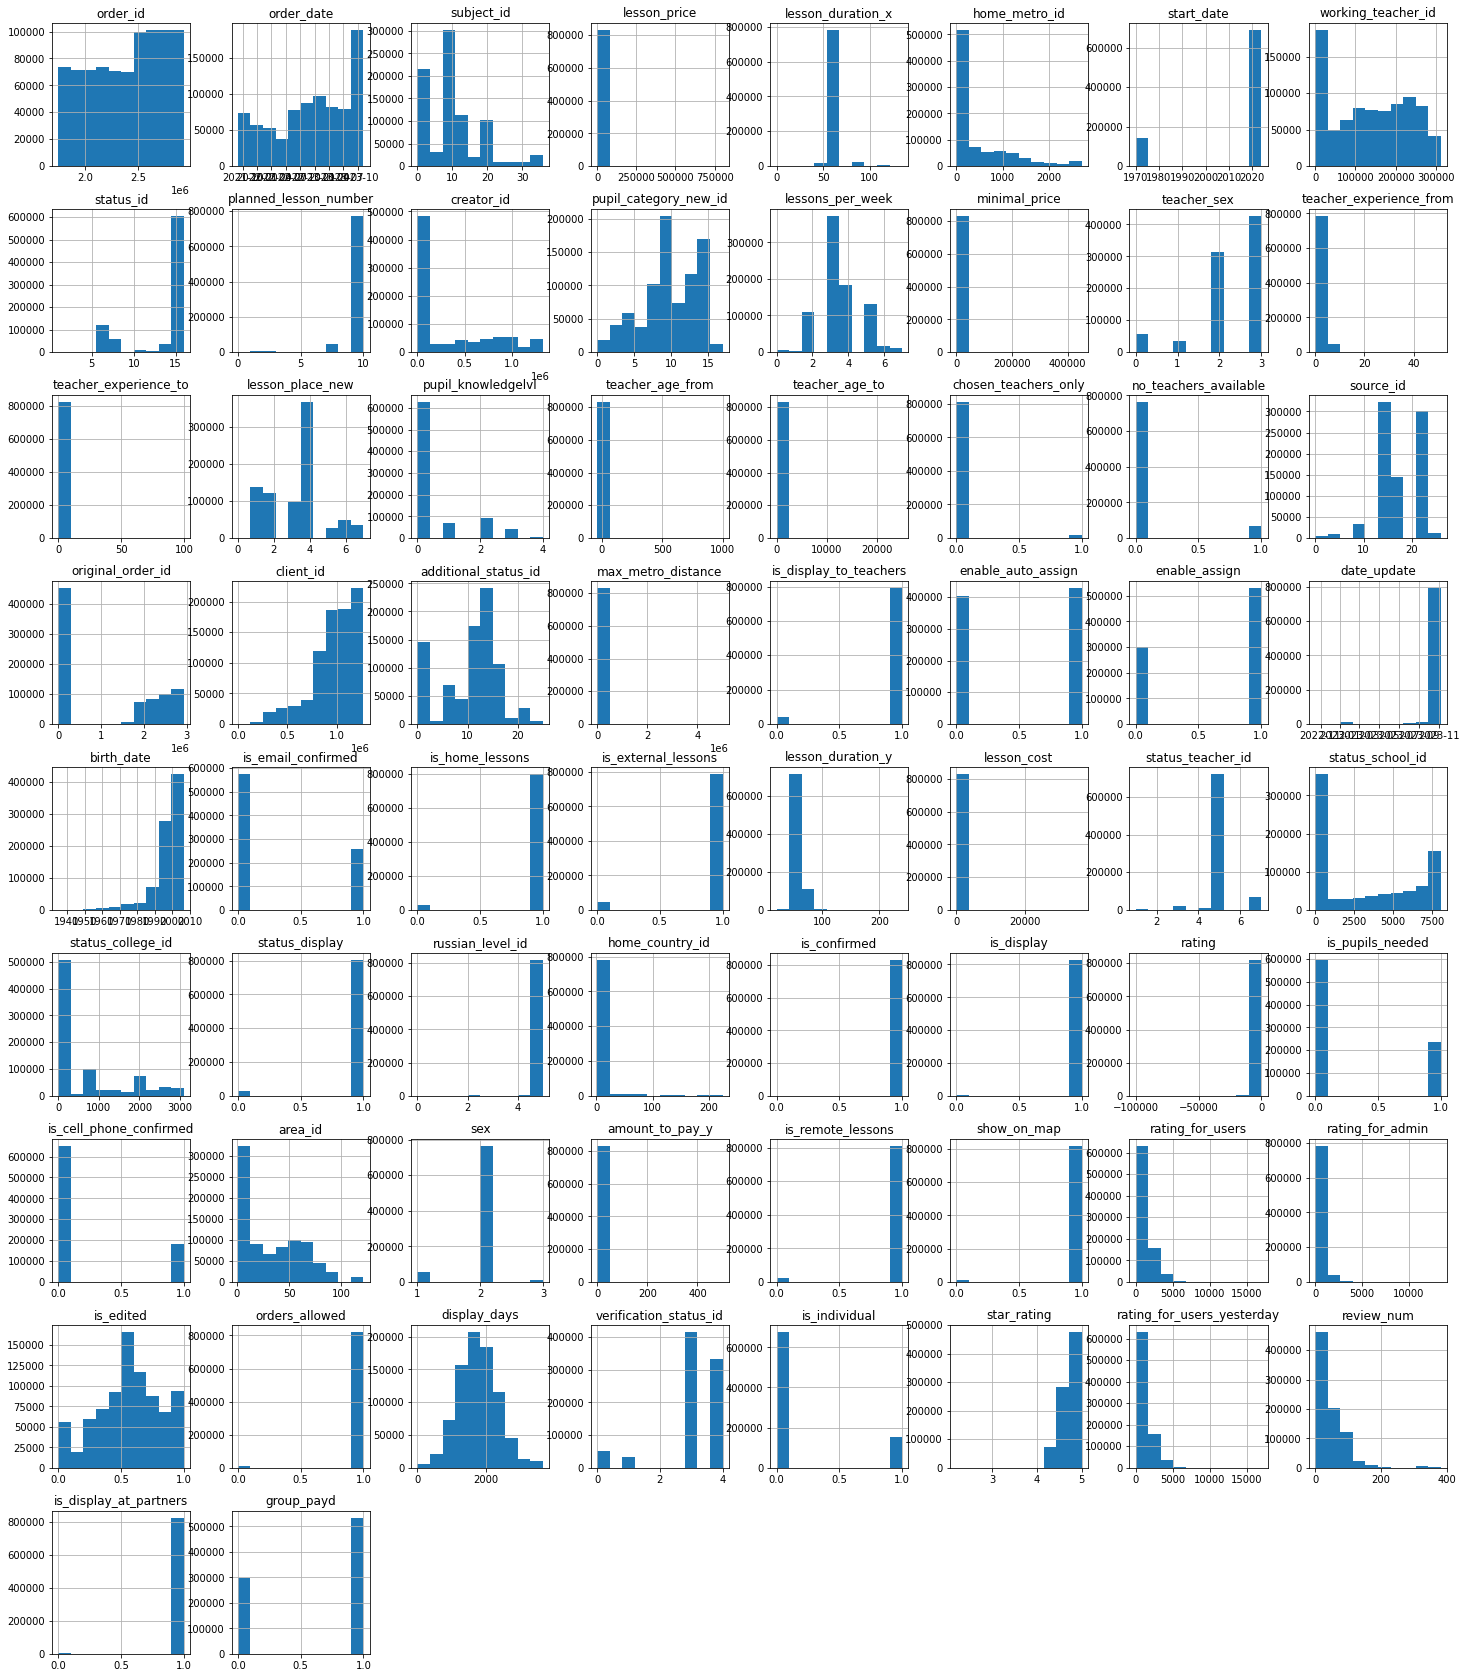

In [61]:
df.hist(figsize=(25,30))
None

#### Изучаю подробнее столбец order_date

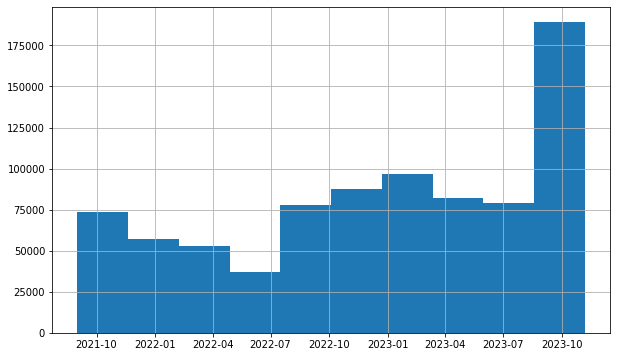

In [62]:
df['order_date'].hist(figsize=(10,6))
None

В предоставленных данных есть информация о заявках с сентября/октября 2021 года по октябрь 2023 года.\
В период с июля 2023 года по октябрь 2023 года произошел резкий скачек количества заявок. Заявок стало вдвое больше по сравнению со всем исследуемым периодом.

#### Изучаю подробнее столбец subject_id

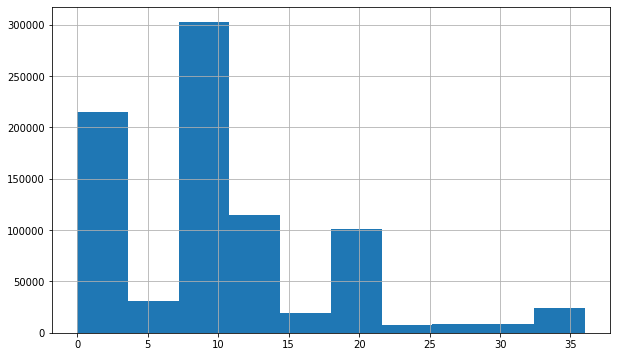

In [63]:
df['subject_id'].hist(figsize=(10,6))
None

Около 200 тыс. заявок поступают вообще без указания предмета.\
Наиболее популярный предмет под кодом 10, а самый не популярный - 25.

#### Изучаю подробнее столбец lesson_price

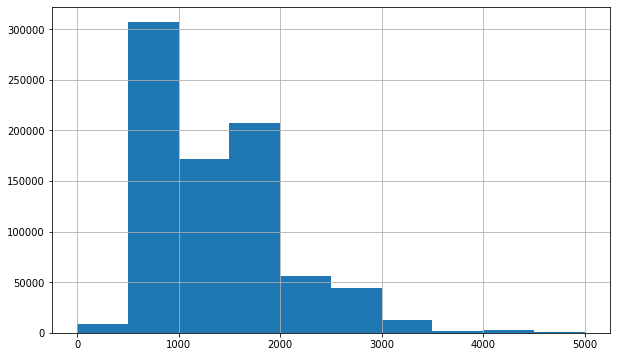

In [64]:
df.query('lesson_price < 5000')['lesson_price'].hist(figsize=(10,6))
None

Стоимость услуг репетитора варьируется от 500 до 5000 рублей. Есть отдельные значения вплоть до 750 000 рублей. Такая стоимость урока выглядит как ошибка. Посчитаю ниже сколько таких значений.

In [65]:
print (df.query('lesson_price > 5000')['lesson_price'].count())

1732


In [66]:
print ("Процент значений с неверно указанной стоимостью урока составляет", ((df.query('lesson_price > 5000')['lesson_price'].count()/df['lesson_price'].count())*100), '%')

Процент значений с неверно указанной стоимостью урока составляет 0.20791068963447573 %


Удаляю строки с ошибочно указанной стоимостью

In [67]:
df = df.query('lesson_price < 5000')

#### Изучаю подробнее столбец start_date

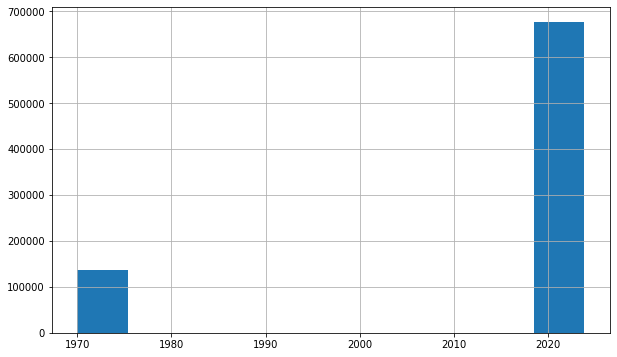

In [68]:
df['start_date'].hist(figsize=(10,6))
None

Значения в этом столбце выглядят очень странно, т.к. период подачи заявок у нас с 2021 по 2023 года. Не очень понятно, что с этим делать, оставляю как есть

#### Изучаю подробнее столбец minimal_price

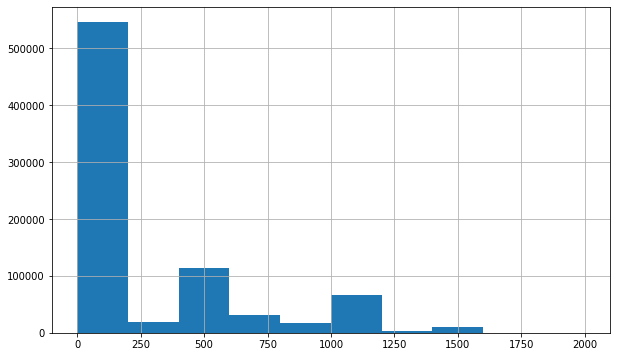

In [69]:
df.query('minimal_price < 2000')['minimal_price'].hist(figsize=(10,6))
None

Минимальная цена варьируется от 250 до 2000 рублей за урок. Значения больше 5000 рублей выглядят как ошибка или выбросы. Ниже считаю сколько таких значений

In [70]:
print (df.query('minimal_price > 5000')['minimal_price'].count())

56


Удаляю строки с ошибочно указанной стоимостью

In [71]:
df = df.query('minimal_price < 5000')

#### Изучаю подробнее столбцы teacher_age_from & teacher_age_to

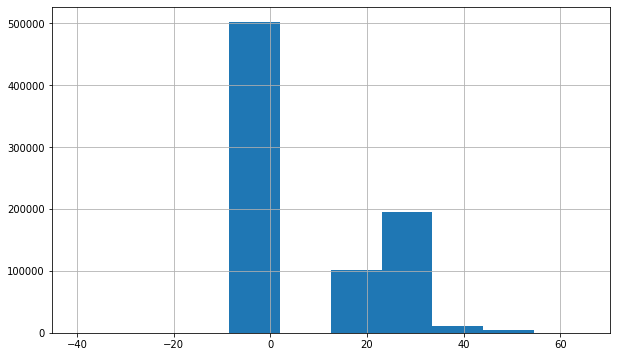

In [72]:
df.query('teacher_age_from < 100')['teacher_age_from'].hist(figsize=(10,6))
None

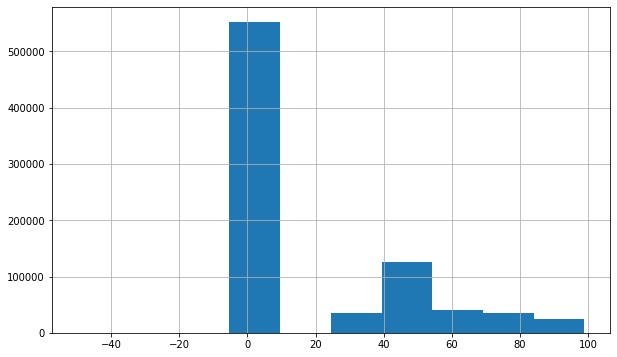

In [73]:
df.query('teacher_age_to < 100')['teacher_age_to'].hist(figsize=(10,6))
None

In [74]:
print (df.query('teacher_age_from > 100')['teacher_age_from'].count())

14


In [75]:
print (df.query('teacher_age_from < 0')['teacher_age_from'].count())

2


In [76]:
print (df.query('teacher_age_to > 100')['teacher_age_to'].count())

6


In [77]:
print (df.query('teacher_age_to < 0')['teacher_age_to'].count())

3


Значения этих столбцов меньше 0 и больше 100 являются явной ошибкой. Таких значений незначительное количество, я их удаляю

In [78]:
df = df.query('teacher_age_from < 100')

In [79]:
df = df.query('teacher_age_to < 100')

#### Изучаю подробнее столбец birth_date

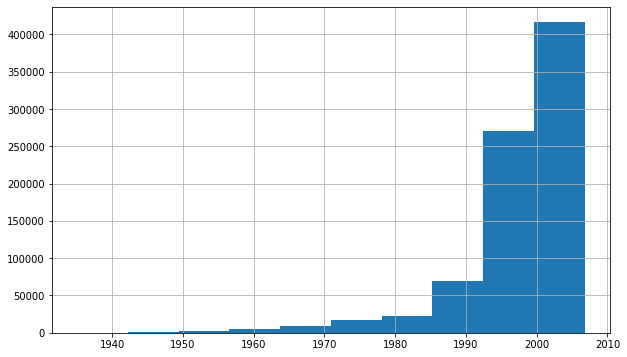

In [80]:
df['birth_date'].hist(figsize=(10,6))
None

In [81]:
print (df['birth_date'].min())

1935-01-24 00:00:00


In [82]:
print (df['birth_date'].max())

2006-10-09 00:00:00


Возраст репетиторов проект от 18 до 89 лет

#### Изучаю подробнее столбец lesson_duration_y

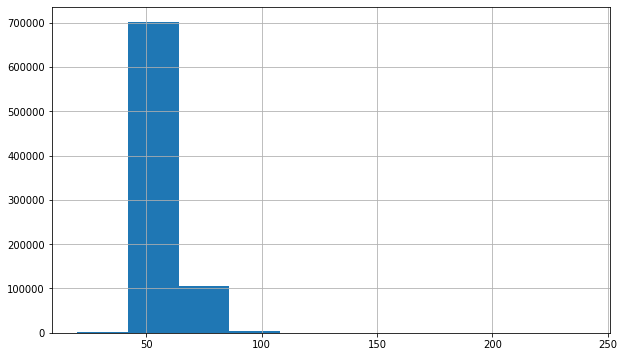

In [83]:
df['lesson_duration_y'].hist(figsize=(10,6))
None

Продолжительность урока дольше 120 минут выглядит как ошибка. Считаю сколько таких значений

In [84]:
print (df.query('lesson_duration_y > 130')['lesson_duration_y'].count())

87


Таких значений незначительное количество, удаляю эти строки

In [85]:
df = df.query('lesson_duration_y < 130')

#### Изучаю подробнее столбец lesson_cost

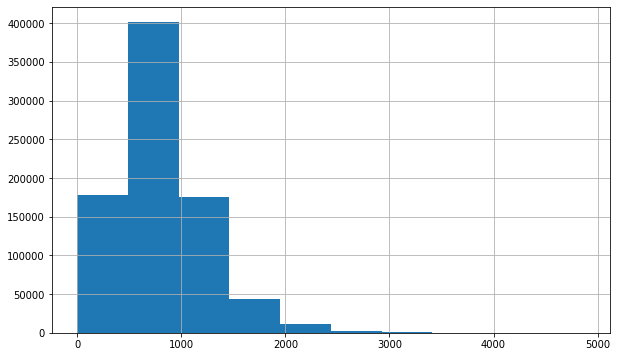

In [86]:
df.query('lesson_cost < 5000')['lesson_cost'].hist(figsize=(10,6))
None

Стоимость урока варьируется от 0 до 5000 рублей. Большинство репетиторов указывают стоимость от 500 до 1000 рублей. Стоимость больше 5000 рублей выглядит как ошибка. Считаю количество таких значений

In [87]:
print (df.query('lesson_cost > 5000')['lesson_cost'].count())

70


Таких строк незначительное количтество, удаляю эти строки

In [88]:
df = df.query('lesson_cost < 5000')

#### Промежуточный вывод:

В предоставленных данных есть информация о заявках с сентября/октября 2021 года по октябрь 2023 года.\
В период с июля 2023 года по октябрь 2023 года произошел резкий скачек количества заявок. Заявок стало вдвое больше по сравнению со всем исследуемым периодом.\
\
Около 200 тыс. заявок поступают вообще без указания предмета.
Наиболее популярный предмет под кодом 10, а самый не популярный - 25.\
\
Стоимость урока (lesson_price), которую пользователи указывают в заявке на поиск репетитора, составляет от 500 до 5000 рублей.\
\
Минимальная цена (minimal_price), которую пользователи указывают в заявке на поиск репетитора, варьируется от 250 до 2000 рублей.\
\
Минимальный возраст репетиторов в заявках варьируется от 18 до 60 лет. \
Максимальный - до 100 лет.\
\
Реальный возраст репетиторов проекта от 18 до 89 лет.\
\
Продолжительность урока, указанная репетирами, составляет от 20 до 120 минут.\
Стоимость урока, указанная репетиторами, составляет от 0 до 5000 рублей. Большинство репетиторов указывают стоимость от 500 до 1000 рублей.\

## Подготовка данных для обучения

### Исследование дисбаланса классов

1    0.644394
0    0.355606
Name: group_payd, dtype: float64


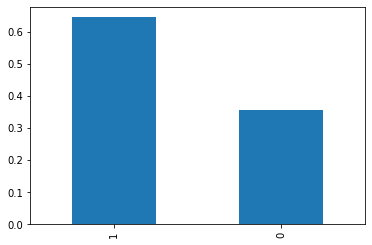

In [89]:
class_frequency = df['group_payd'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
None

Выявлен дисбаланс классов. Но в нашем случае дисбаланс не сильно критичный. Метрика ROC-AUC устойчива к дисбалансу классов, поэтому нам можно не проводить балансировку классов. 

### Разбиваю данные на выборки

Запускаю код для уменьшения потребления памяти

In [90]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [117]:
features = df.drop(['order_id', 'order_date', 'subject_id', 'purpose', 'home_metro_id', 'add_info', 'start_date', 'working_teacher_id', 'status_id', 'comments', 'creator_id', 'pupil_category_new_id',\
        'source_id', 'original_order_id', 'client_id', 'additional_status_id', 'date_update', 'birth_date', 'status_teacher_id', 'status_relevant_date', 'status_school_id',\
        'status_college_id', 'russian_level_id', 'home_country_id', 'area_id', 'verification_status_id', 'estimated_fee', 'first_lesson_date', 'payment_date', 'group_payd',\
                   'amount_to_pay_x', 'last_visited', 'chosen_teachers_only', 'no_teachers_available', 'pupil_knowledgelvl', 'show_on_map', 'is_email_confirmed', 'is_display_to_teachers', \
                   'lessons_per_week'], axis=1)
target = df['group_payd']

features_train, features_test, target_train, target_test = train_test_split(features, \
                                                                            target, \
                                                                            test_size=0.25, \
                                                                            random_state=123456, \
                                                                           stratify=target) #делю данные 65-25%

print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

Количество строк в target_train по классам: [216763 392796]
Количество строк в target_test по классам: [ 72254 130933]


In [92]:
display (features_train.head(5))

,lesson_price,lesson_duration_x,planned_lesson_number,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,teacher_age_from,teacher_age_to,max_metro_distance,is_display_to_teachers,enable_auto_assign,enable_assign,is_home_lessons,is_external_lessons,lesson_duration_y,lesson_cost,status_display,is_confirmed,is_display,rating,is_pupils_needed,is_cell_phone_confirmed,sex,amount_to_pay_y,is_remote_lessons,rating_for_users,rating_for_admin,is_edited,orders_allowed,display_days,is_individual,star_rating,rating_for_users_yesterday,review_num,is_display_at_partners
762425,1500,60,10,3,0,2,0,0,1,0,0,0.0,1,0,1,1.0,1.0,60.000000,586.666667,1.0,1.0,1.0,5.133333,0.0,0.0,2.0,0.0,1.0,571.000,134.62500,0.133333,1.0,1250.0,0.0,4.468750,571.000,11.0,1.0
670513,1000,60,10,2,400,3,0,0,1,0,0,0.0,1,1,0,1.0,1.0,60.000000,583.333333,1.0,1.0,1.0,5.333333,0.0,0.0,2.0,0.0,1.0,420.500,223.25000,0.400000,1.0,1420.0,0.0,4.527344,420.500,13.0,1.0
111256,500,45,10,3,0,3,0,0,1,0,0,0.0,1,1,1,1.0,1.0,63.888889,485.185185,1.0,1.0,1.0,3.962963,0.0,0.0,2.0,0.0,1.0,129.875,32.00000,0.629630,1.0,1774.0,0.0,4.421875,129.875,4.0,1.0
67870,500,60,10,7,0,2,0,0,1,19,50,0.0,1,1,1,1.0,1.0,60.000000,475.000000,1.0,1.0,1.0,4.333333,0.0,0.0,2.0,0.0,1.0,242.875,53.65625,0.666667,1.0,1731.0,0.0,4.601562,242.875,12.0,1.0
398381,800,60,10,3,500,2,0,0,2,0,0,0.0,1,0,1,1.0,1.0,57.857143,385.714286,1.0,1.0,1.0,5.142857,0.0,0.0,2.0,0.0,1.0,335.750,76.37500,0.142857,1.0,1068.0,0.0,4.328125,341.000,2.0,1.0


### Масштабирую количественные данные

In [118]:
numeric = ['lesson_price', 'lesson_duration_x', 'planned_lesson_number', 'minimal_price', 'teacher_experience_from', 'teacher_experience_to', 'lesson_place_new',\
          'teacher_age_from', 'teacher_age_to', 'max_metro_distance', 'lesson_duration_y', 'lesson_cost', 'rating', 'amount_to_pay_y', 'rating_for_users', 'rating_for_admin',\
          'is_edited', 'display_days', 'star_rating', 'rating_for_users_yesterday', 'review_num']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
display (features_train.head(5))
display (features_test.head(5))

(609559, 36)


,lesson_price,lesson_duration_x,planned_lesson_number,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,teacher_age_from,teacher_age_to,max_metro_distance,enable_auto_assign,enable_assign,is_home_lessons,is_external_lessons,lesson_duration_y,lesson_cost,status_display,is_confirmed,is_display,rating,is_pupils_needed,is_cell_phone_confirmed,sex,amount_to_pay_y,is_remote_lessons,rating_for_users,rating_for_admin,is_edited,orders_allowed,display_days,is_individual,star_rating,rating_for_users_yesterday,review_num,is_display_at_partners
762425,0.451866,-0.116850,0.240706,-0.595295,2,-0.543027,-0.100339,-1.520370,-0.755070,-0.641864,-0.001353,0,1,1.0,1.0,-0.100723,-0.506402,1.0,1.0,1.0,0.152964,0.0,0.0,2.0,-0.004483,1.0,-0.613482,-0.764513,-1.599121,1.0,-0.876367,0.0,-1.319888,-0.613773,-0.706934,1.0
670513,-0.360630,-0.116850,0.240706,0.397199,3,-0.543027,-0.100339,-1.520370,-0.755070,-0.641864,-0.001353,1,0,1.0,1.0,-0.100723,-0.514228,1.0,1.0,1.0,0.153011,0.0,0.0,2.0,-0.004483,1.0,-0.761642,-0.579006,-0.588937,1.0,-0.586744,0.0,-1.020323,-0.761865,-0.664857,1.0
111256,-1.173125,-1.985434,0.240706,-0.595295,3,-0.543027,-0.100339,-1.520370,-0.755070,-0.641864,-0.001353,1,1,1.0,1.0,0.686585,-0.744668,1.0,1.0,1.0,0.152688,0.0,0.0,2.0,-0.004483,1.0,-1.047747,-0.979324,0.280943,1.0,0.016353,0.0,-1.559539,-1.047840,-0.854204,1.0
67870,-1.173125,-0.116850,0.240706,-0.595295,2,-0.543027,-0.100339,-1.520370,0.793576,1.158089,-0.001353,1,1,1.0,1.0,-0.100723,-0.768581,1.0,1.0,1.0,0.152775,0.0,0.0,2.0,-0.004483,1.0,-0.936504,-0.933994,0.421246,1.0,-0.056904,0.0,-0.640875,-0.936648,-0.685895,1.0
398381,-0.685628,-0.116850,0.240706,0.645323,2,-0.543027,-0.100339,-0.876401,-0.755070,-0.641864,-0.001353,0,1,1.0,1.0,-0.534546,-0.978213,1.0,1.0,1.0,0.152966,0.0,0.0,2.0,-0.004483,1.0,-0.845074,-0.886440,-1.563043,1.0,-1.186433,0.0,-2.038843,-0.840093,-0.896281,1.0


,lesson_price,lesson_duration_x,planned_lesson_number,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,teacher_age_from,teacher_age_to,max_metro_distance,enable_auto_assign,enable_assign,is_home_lessons,is_external_lessons,lesson_duration_y,lesson_cost,status_display,is_confirmed,is_display,rating,is_pupils_needed,is_cell_phone_confirmed,sex,amount_to_pay_y,is_remote_lessons,rating_for_users,rating_for_admin,is_edited,orders_allowed,display_days,is_individual,star_rating,rating_for_users_yesterday,review_num,is_display_at_partners
445809,0.451866,-0.11685,0.240706,-0.595295,2,-0.543027,-0.100339,0.411537,-0.75507,-0.641864,-0.001353,0,0,1.0,1.0,-0.100723,1.097979,1.0,1.0,1.0,0.153262,0.0,0.0,2.0,-0.004483,1.0,3.459175,3.441447,0.926338,1.0,0.639894,0.0,0.377645,3.449166,0.429148,1.0
413591,0.451866,-0.11685,0.240706,-0.595295,3,-0.543027,-0.100339,-0.232432,-0.75507,-0.641864,-0.001353,0,1,1.0,1.0,-1.000504,-0.357703,1.0,1.0,1.0,0.153168,0.0,0.0,2.0,-0.004483,1.0,-0.372293,-0.618776,-0.420573,1.0,-0.622521,0.0,-0.201513,-0.374660,0.786803,1.0
797544,0.451866,-0.11685,0.240706,1.141570,2,0.180452,-0.100339,1.699475,-0.75507,-0.641864,-0.001353,1,0,1.0,1.0,0.089075,1.036347,1.0,1.0,1.0,0.153271,1.0,1.0,2.0,-0.004483,1.0,1.084689,0.598924,0.263405,1.0,0.534267,0.0,0.058110,1.071821,1.018227,1.0
523628,-0.523129,-0.11685,0.240706,-0.595295,0,-0.543027,-0.100339,0.411537,-0.75507,-0.641864,-0.001353,0,0,1.0,1.0,-0.039988,-0.283511,1.0,1.0,1.0,0.153158,1.0,0.0,2.0,-0.004483,1.0,0.080553,0.034816,-0.588937,1.0,-0.731555,1.0,0.517442,0.080932,0.366032,1.0
618555,-0.786377,-0.11685,0.240706,0.149075,3,-0.543027,-0.100339,-0.876401,-0.75507,-0.641864,-0.001353,0,1,1.0,1.0,-3.137483,-0.153438,1.0,1.0,1.0,0.152932,0.0,0.0,1.0,-0.004483,1.0,-0.112399,-0.313697,-2.104213,1.0,-1.667718,0.0,-2.178640,-0.112916,-0.938358,1.0


### Кодирую категориальные значения

In [119]:
categories = ['enable_auto_assign', 'enable_assign', \
             'is_home_lessons', 'is_external_lessons', 'status_display', 'is_confirmed', 'is_display', 'is_pupils_needed', 'is_cell_phone_confirmed', 'sex', 'is_remote_lessons',\
             'orders_allowed', 'is_individual', 'is_display_at_partners', 'teacher_sex']
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='error', drop='first')

result_train_ohe = onehot_encoder.fit_transform(features_train[categories])
result_train = pd.DataFrame(result_train_ohe, columns=onehot_encoder.get_feature_names_out(categories),\
                                                                        index=features_train.index)
features_train_ohe = result_train.join(features_train[numeric])
features_train_ohe.head()

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,enable_auto_assign_1,enable_assign_1,is_home_lessons_1.0,is_external_lessons_1.0,status_display_1.0,is_confirmed_1.0,is_display_1.0,is_pupils_needed_1.0,is_cell_phone_confirmed_1.0,sex_2.0,sex_3.0,is_remote_lessons_1.0,orders_allowed_1.0,is_individual_1.0,is_display_at_partners_1.0,teacher_sex_1,teacher_sex_2,teacher_sex_3,lesson_price,lesson_duration_x,planned_lesson_number,minimal_price,teacher_experience_from,teacher_experience_to,lesson_place_new,teacher_age_from,teacher_age_to,max_metro_distance,lesson_duration_y,lesson_cost,rating,amount_to_pay_y,rating_for_users,rating_for_admin,is_edited,display_days,star_rating,rating_for_users_yesterday,review_num
762425,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.451866,-0.116850,0.240706,-0.595295,-0.543027,-0.100339,-1.520370,-0.755070,-0.641864,-0.001353,-0.100723,-0.506402,0.152964,-0.004483,-0.613482,-0.764513,-1.599121,-0.876367,-1.319888,-0.613773,-0.706934
670513,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,-0.360630,-0.116850,0.240706,0.397199,-0.543027,-0.100339,-1.520370,-0.755070,-0.641864,-0.001353,-0.100723,-0.514228,0.153011,-0.004483,-0.761642,-0.579006,-0.588937,-0.586744,-1.020323,-0.761865,-0.664857
111256,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,-1.173125,-1.985434,0.240706,-0.595295,-0.543027,-0.100339,-1.520370,-0.755070,-0.641864,-0.001353,0.686585,-0.744668,0.152688,-0.004483,-1.047747,-0.979324,0.280943,0.016353,-1.559539,-1.047840,-0.854204
67870,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,-1.173125,-0.116850,0.240706,-0.595295,-0.543027,-0.100339,-1.520370,0.793576,1.158089,-0.001353,-0.100723,-0.768581,0.152775,-0.004483,-0.936504,-0.933994,0.421246,-0.056904,-0.640875,-0.936648,-0.685895
398381,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.685628,-0.116850,0.240706,0.645323,-0.543027,-0.100339,-0.876401,-0.755070,-0.641864,-0.001353,-0.534546,-0.978213,0.152966,-0.004483,-0.845074,-0.886440,-1.563043,-1.186433,-2.038843,-0.840093,-0.896281


In [120]:
result_test_ohe = onehot_encoder.transform(features_test[categories])
result_test = pd.DataFrame(result_test_ohe, columns=onehot_encoder.get_feature_names_out(categories),\
                                                                        index=features_test.index)
features_test_ohe = result_test.join(features_test[numeric])
features_test_ohe.head()

,enable_auto_assign_1,enable_assign_1,is_home_lessons_1.0,is_external_lessons_1.0,status_display_1.0,is_confirmed_1.0,is_display_1.0,is_pupils_needed_1.0,is_cell_phone_confirmed_1.0,sex_2.0,sex_3.0,is_remote_lessons_1.0,orders_allowed_1.0,is_individual_1.0,is_display_at_partners_1.0,teacher_sex_1,teacher_sex_2,teacher_sex_3,lesson_price,lesson_duration_x,planned_lesson_number,minimal_price,teacher_experience_from,teacher_experience_to,lesson_place_new,teacher_age_from,teacher_age_to,max_metro_distance,lesson_duration_y,lesson_cost,rating,amount_to_pay_y,rating_for_users,rating_for_admin,is_edited,display_days,star_rating,rating_for_users_yesterday,review_num
445809,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.451866,-0.11685,0.240706,-0.595295,-0.543027,-0.100339,0.411537,-0.75507,-0.641864,-0.001353,-0.100723,1.097979,0.153262,-0.004483,3.459175,3.441447,0.926338,0.639894,0.377645,3.449166,0.429148
413591,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.451866,-0.11685,0.240706,-0.595295,-0.543027,-0.100339,-0.232432,-0.75507,-0.641864,-0.001353,-1.000504,-0.357703,0.153168,-0.004483,-0.372293,-0.618776,-0.420573,-0.622521,-0.201513,-0.374660,0.786803
797544,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.451866,-0.11685,0.240706,1.141570,0.180452,-0.100339,1.699475,-0.75507,-0.641864,-0.001353,0.089075,1.036347,0.153271,-0.004483,1.084689,0.598924,0.263405,0.534267,0.058110,1.071821,1.018227
523628,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,-0.523129,-0.11685,0.240706,-0.595295,-0.543027,-0.100339,0.411537,-0.75507,-0.641864,-0.001353,-0.039988,-0.283511,0.153158,-0.004483,0.080553,0.034816,-0.588937,-0.731555,0.517442,0.080932,0.366032
618555,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,-0.786377,-0.11685,0.240706,0.149075,-0.543027,-0.100339,-0.876401,-0.75507,-0.641864,-0.001353,-3.137483,-0.153438,0.152932,-0.004483,-0.112399,-0.313697,-2.104213,-1.667718,-2.178640,-0.112916,-0.938358


#### Для исследования моделей, основанных на деревьях решений, использую порядковое кодирование

In [121]:
# порядковое кодирование
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ['enable_auto_assign', 'enable_assign', \
             'is_home_lessons', 'is_external_lessons', 'status_display', 'is_confirmed', 'is_display', 'is_pupils_needed', 'is_cell_phone_confirmed', 'sex', 'is_remote_lessons',\
             'orders_allowed', 'is_individual', 'is_display_at_partners', 'teacher_sex']
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

### Масштабирую признаки столбцов

In [122]:
numeric = ['lesson_price', 'lesson_duration_x', 'planned_lesson_number', 'minimal_price', 'teacher_experience_from', 'teacher_experience_to', 'lesson_place_new',\
          'teacher_age_from', 'teacher_age_to', 'max_metro_distance', 'lesson_duration_y', 'lesson_cost', 'rating', 'amount_to_pay_y', 'rating_for_users', 'rating_for_admin',\
          'is_edited', 'display_days', 'star_rating', 'rating_for_users_yesterday', 'review_num']

scaler = StandardScaler()
scaler.fit(features_train_ord[numeric])
features_train_ord[numeric] = scaler.transform(features_train_ord[numeric])
features_test_ord[numeric] = scaler.transform(features_test_ord[numeric])

print(features_train_ord.shape)
display (features_train_ord.head(5))
display (features_test_ord.head(5))

(609559, 36)


,lesson_price,lesson_duration_x,planned_lesson_number,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,teacher_age_from,teacher_age_to,max_metro_distance,enable_auto_assign,enable_assign,is_home_lessons,is_external_lessons,lesson_duration_y,lesson_cost,status_display,is_confirmed,is_display,rating,is_pupils_needed,is_cell_phone_confirmed,sex,amount_to_pay_y,is_remote_lessons,rating_for_users,rating_for_admin,is_edited,orders_allowed,display_days,is_individual,star_rating,rating_for_users_yesterday,review_num,is_display_at_partners
762425,0.451866,-0.116850,0.240706,-0.595295,2.0,-0.543027,-0.100339,-1.520370,-0.755070,-0.641864,-0.001353,0.0,1.0,1.0,1.0,-0.100723,-0.506402,1.0,1.0,1.0,0.152964,0.0,0.0,1.0,-0.004483,1.0,-0.613482,-0.764513,-1.599121,1.0,-0.876367,0.0,-1.319888,-0.613773,-0.706934,1.0
670513,-0.360630,-0.116850,0.240706,0.397199,3.0,-0.543027,-0.100339,-1.520370,-0.755070,-0.641864,-0.001353,1.0,0.0,1.0,1.0,-0.100723,-0.514228,1.0,1.0,1.0,0.153011,0.0,0.0,1.0,-0.004483,1.0,-0.761642,-0.579006,-0.588937,1.0,-0.586744,0.0,-1.020323,-0.761865,-0.664857,1.0
111256,-1.173125,-1.985434,0.240706,-0.595295,3.0,-0.543027,-0.100339,-1.520370,-0.755070,-0.641864,-0.001353,1.0,1.0,1.0,1.0,0.686585,-0.744668,1.0,1.0,1.0,0.152688,0.0,0.0,1.0,-0.004483,1.0,-1.047747,-0.979324,0.280943,1.0,0.016353,0.0,-1.559539,-1.047840,-0.854204,1.0
67870,-1.173125,-0.116850,0.240706,-0.595295,2.0,-0.543027,-0.100339,-1.520370,0.793576,1.158089,-0.001353,1.0,1.0,1.0,1.0,-0.100723,-0.768581,1.0,1.0,1.0,0.152775,0.0,0.0,1.0,-0.004483,1.0,-0.936504,-0.933994,0.421246,1.0,-0.056904,0.0,-0.640875,-0.936648,-0.685895,1.0
398381,-0.685628,-0.116850,0.240706,0.645323,2.0,-0.543027,-0.100339,-0.876401,-0.755070,-0.641864,-0.001353,0.0,1.0,1.0,1.0,-0.534546,-0.978213,1.0,1.0,1.0,0.152966,0.0,0.0,1.0,-0.004483,1.0,-0.845074,-0.886440,-1.563043,1.0,-1.186433,0.0,-2.038843,-0.840093,-0.896281,1.0


,lesson_price,lesson_duration_x,planned_lesson_number,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,teacher_age_from,teacher_age_to,max_metro_distance,enable_auto_assign,enable_assign,is_home_lessons,is_external_lessons,lesson_duration_y,lesson_cost,status_display,is_confirmed,is_display,rating,is_pupils_needed,is_cell_phone_confirmed,sex,amount_to_pay_y,is_remote_lessons,rating_for_users,rating_for_admin,is_edited,orders_allowed,display_days,is_individual,star_rating,rating_for_users_yesterday,review_num,is_display_at_partners
445809,0.451866,-0.11685,0.240706,-0.595295,2.0,-0.543027,-0.100339,0.411537,-0.75507,-0.641864,-0.001353,0.0,0.0,1.0,1.0,-0.100723,1.097979,1.0,1.0,1.0,0.153262,0.0,0.0,1.0,-0.004483,1.0,3.459175,3.441447,0.926338,1.0,0.639894,0.0,0.377645,3.449166,0.429148,1.0
413591,0.451866,-0.11685,0.240706,-0.595295,3.0,-0.543027,-0.100339,-0.232432,-0.75507,-0.641864,-0.001353,0.0,1.0,1.0,1.0,-1.000504,-0.357703,1.0,1.0,1.0,0.153168,0.0,0.0,1.0,-0.004483,1.0,-0.372293,-0.618776,-0.420573,1.0,-0.622521,0.0,-0.201513,-0.374660,0.786803,1.0
797544,0.451866,-0.11685,0.240706,1.141570,2.0,0.180452,-0.100339,1.699475,-0.75507,-0.641864,-0.001353,1.0,0.0,1.0,1.0,0.089075,1.036347,1.0,1.0,1.0,0.153271,1.0,1.0,1.0,-0.004483,1.0,1.084689,0.598924,0.263405,1.0,0.534267,0.0,0.058110,1.071821,1.018227,1.0
523628,-0.523129,-0.11685,0.240706,-0.595295,0.0,-0.543027,-0.100339,0.411537,-0.75507,-0.641864,-0.001353,0.0,0.0,1.0,1.0,-0.039988,-0.283511,1.0,1.0,1.0,0.153158,1.0,0.0,1.0,-0.004483,1.0,0.080553,0.034816,-0.588937,1.0,-0.731555,1.0,0.517442,0.080932,0.366032,1.0
618555,-0.786377,-0.11685,0.240706,0.149075,3.0,-0.543027,-0.100339,-0.876401,-0.75507,-0.641864,-0.001353,0.0,1.0,1.0,1.0,-3.137483,-0.153438,1.0,1.0,1.0,0.152932,0.0,0.0,0.0,-0.004483,1.0,-0.112399,-0.313697,-2.104213,1.0,-1.667718,0.0,-2.178640,-0.112916,-0.938358,1.0


### Исследую модель случайного леса. Гиперпараметры подбираю через GridSearch

In [123]:
kf = StratifiedKFold(n_splits=5)

%%time

clf = RandomForestClassifier (random_state=123456) #объявляем классификатор

param = { 'n_estimators': range(50, 200, 50), 'max_depth': [None] + [i for i in range(2, 7)] } #задаем параметры классификатора

grid = GridSearchCV(estimator = clf,
                    param_grid = param,
                    cv = kf,
                    n_jobs = -1,
                    verbose = 0,
                    scoring = 'roc_auc') #запускаем обучение
grid.fit(features_train_ord, target_train)

print ('Roc-auc наилучшей модели', grid.best_score_) #выводим наилучшую метрику
print ('Какие гиперпараметры дали наилучший результат', grid.best_params_) #выводим наилучшие параметры модели

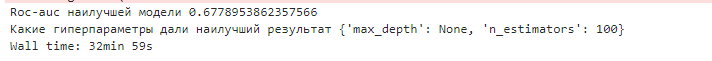

### Исследую модель LightGBM

In [125]:
%%time

clf = lgb.LGBMClassifier (boosting_type='gbdt',  objective='binary', \
                          learning_rate=0.02, metric='roc_auc', random_state=123456) #объявляем классификатор

param = { 'n_estimators': range(50, 200, 50), 'max_depth': [i for i in range(3, 12)]} #задаем параметры классификатора

grid = GridSearchCV(estimator = clf,
                    param_grid = param,
                    cv = kf,
                    n_jobs = -1,
                    verbose = 0,
                    scoring='roc_auc') #запускаем обучение
grid.fit(features_train_ohe, target_train)

print ('Roc-auc наилучшей модели', grid.best_score_) #выводим наилучшую метрику
print ('Какие гиперпараметры дали наилучший результат', grid.best_params_) #выводим наилучшие параметры модели

Roc-auc наилучшей модели 0.6860138561525941
Какие гиперпараметры дали наилучший результат {'max_depth': 11, 'n_estimators': 150}
Wall time: 6min 27s


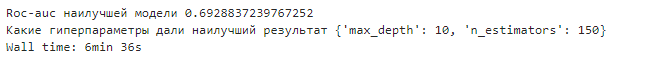

### Исследую модель CatBoost

In [101]:
%%time

clf = CatBoostClassifier (random_state=123456) #объявляем классификатор

param = {'max_depth': [i for i in range(5, 12)],
                  'learning_rate':[0.01, 0.1],
                  'iterations': [400, 500]}  #задаем параметры классификатор


grid = GridSearchCV(estimator = clf,
                    param_grid = param,
                    cv = kf, #записываю сюда параметры стратификатора kf
                    n_jobs = -1,
                    verbose = 0,
                    scoring = 'roc_auc') #запускаем обучение
grid.fit(features_train_ohe, target_train)
print(grid.best_params_)
grid.best_score_

0:	learn: 0.6745464	total: 261ms	remaining: 2m 10s
1:	learn: 0.6594415	total: 425ms	remaining: 1m 45s
2:	learn: 0.6474182	total: 606ms	remaining: 1m 40s
3:	learn: 0.6380675	total: 760ms	remaining: 1m 34s
4:	learn: 0.6302637	total: 914ms	remaining: 1m 30s
5:	learn: 0.6242282	total: 1.07s	remaining: 1m 28s
6:	learn: 0.6193306	total: 1.22s	remaining: 1m 25s
7:	learn: 0.6152173	total: 1.36s	remaining: 1m 23s
8:	learn: 0.6118109	total: 1.51s	remaining: 1m 22s
9:	learn: 0.6090010	total: 1.65s	remaining: 1m 20s
10:	learn: 0.6068137	total: 1.79s	remaining: 1m 19s
11:	learn: 0.6049308	total: 1.93s	remaining: 1m 18s
12:	learn: 0.6033385	total: 2.07s	remaining: 1m 17s
13:	learn: 0.6019416	total: 2.21s	remaining: 1m 16s
14:	learn: 0.6008270	total: 2.35s	remaining: 1m 15s
15:	learn: 0.5998548	total: 2.48s	remaining: 1m 15s
16:	learn: 0.5990442	total: 2.63s	remaining: 1m 14s
17:	learn: 0.5984269	total: 2.76s	remaining: 1m 13s
18:	learn: 0.5978158	total: 2.89s	remaining: 1m 13s
19:	learn: 0.5972047	t

0.7012821400844876

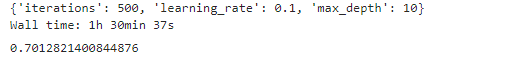

### Тестирование модели

Наилучший результат показала модель CatBoost

In [110]:
best_model = CatBoostClassifier(random_state=123456,
                           iterations = 500,
                           learning_rate = 0.1,
                           max_depth = 10).fit(features_train_ohe, target_train)

0:	learn: 0.6745464	total: 158ms	remaining: 1m 18s
1:	learn: 0.6594415	total: 304ms	remaining: 1m 15s
2:	learn: 0.6474182	total: 455ms	remaining: 1m 15s
3:	learn: 0.6380675	total: 595ms	remaining: 1m 13s
4:	learn: 0.6302637	total: 741ms	remaining: 1m 13s
5:	learn: 0.6242282	total: 883ms	remaining: 1m 12s
6:	learn: 0.6193306	total: 1.04s	remaining: 1m 12s
7:	learn: 0.6152173	total: 1.18s	remaining: 1m 12s
8:	learn: 0.6118109	total: 1.33s	remaining: 1m 12s
9:	learn: 0.6090010	total: 1.48s	remaining: 1m 12s
10:	learn: 0.6068137	total: 1.62s	remaining: 1m 12s
11:	learn: 0.6049308	total: 1.76s	remaining: 1m 11s
12:	learn: 0.6033385	total: 1.9s	remaining: 1m 11s
13:	learn: 0.6019416	total: 2.05s	remaining: 1m 11s
14:	learn: 0.6008270	total: 2.19s	remaining: 1m 10s
15:	learn: 0.5998548	total: 2.34s	remaining: 1m 10s
16:	learn: 0.5990442	total: 2.48s	remaining: 1m 10s
17:	learn: 0.5984269	total: 2.62s	remaining: 1m 10s
18:	learn: 0.5978158	total: 2.75s	remaining: 1m 9s
19:	learn: 0.5972047	tot

In [111]:
y_pred_proba = best_model.predict_proba(features_test_ohe)[:, 1]
auc_roc = roc_auc_score(target_test, y_pred_proba)

print('AUC-ROC на тестовой выборке:', round(auc_roc, 4))

AUC-ROC на тестовой выборке: 0.7024


### Вывожу матрицу ошибок

Записываю предсказания модели в отдельную переменную test_preds

In [112]:
test_preds = best_model.predict(features_test_ohe)
print (test_preds)

[1 1 1 ... 0 1 0]


Округляю предсказания и создаю переменную "Предсказанная вероятность - preds_probability"

In [113]:
preds = pd.DataFrame(test_preds)
preds_probability = round(preds,0)
print (preds_probability)

        0
0       1
1       1
2       1
3       0
4       1
...    ..
203182  1
203183  1
203184  0
203185  1
203186  0

[203187 rows x 1 columns]


Создаю матрицу ошибок

In [114]:
confusion_matrix(target_test, preds_probability)

array([[ 30545,  41709],
       [ 22230, 108703]], dtype=int64)

Результат матрицы ошибок:\
Истинно позитивное предсказание 30545, ошибочно негативные 41709, ошибочно положительные 22230, ошибочно отрицательное 108703

Вычисляю Accuracy для лучшей модели

In [115]:
Accuracy = accuracy_score(preds_probability, target_test)
print (Accuracy)

0.6853194348063606


### Исследую важность признаков у лучшей модели

In [116]:
# сгенерируем оценщик значений Шепли, который соответствует построенной модели 
explainer = shap.TreeExplainer(best_model, feature_perturbation='interventional')
# вычислим значения Шепли для тестовой выборки
shap_values = explainer.shap_values(features_test_ohe)

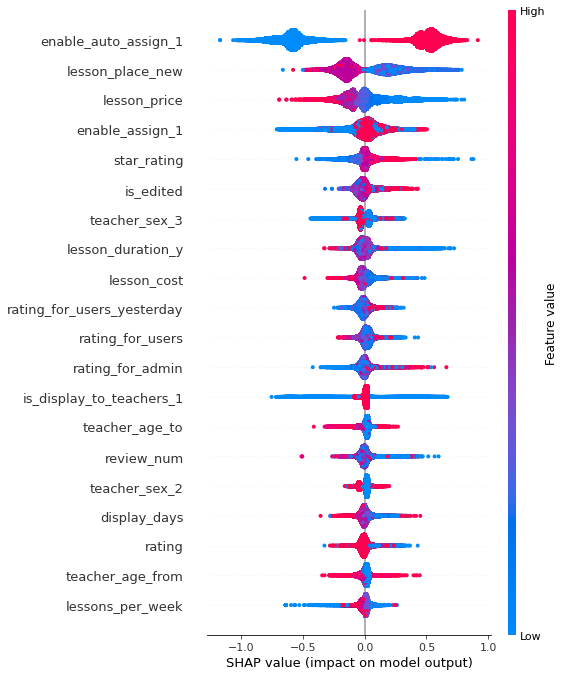

In [109]:
shap.summary_plot(shap_values, features_test_ohe)

Наибольшее влияние на модель оказали такие признаки как: enable_auto_assign, star_rating, is_edited

## Вывод

Сервис Repetit.ru работает с большим количеством заявок от клиентов с данными о предмете, желаемой стоимости, возрасте ученика, целью занятий и тд. К сожалению, 7 из 8 не доходят до оплаты, при этом обработка заявки консультантом увеличивает конверсию в оплату на 30%.\
Проблема в том, что консультантов не хватает на все заявки и получается, что чем больше заявок — тем меньше конверсия из заявки в оплату и консультанты тратят время на бесперспективные заявки.\
\
\
Задачей данного проекта является hазработать модель, которая по имеющейся информации о клиенте и заявке будет предсказывать вероятность оплаты заявки клиентом. Заказчик хочет понять, какие заявки будут оплачены, а какие нет, чтобы одни обрабатывать вручную консультантами, а другие нет. Оценка качества модели будет производиться с использованием precision и ROC-AUC.\
\
Задачей является задача бинарной классификации заявок от клиентов.\
\
\
В предоставленных данных есть информация о заявках с сентября/октября 2021 года по октябрь 2023 года.\
В период с июля 2023 года по октябрь 2023 года произошел резкий скачек количества заявок. Заявок стало вдвое больше по сравнению со всем исследуемым периодом.\
\
Около 200 тыс. заявок поступают вообще без указания предмета. Наиболее популярный предмет под кодом 10, а самый не популярный - 25.\
\
Стоимость урока (lesson_price), которую пользователи указывают в заявке на поиск репетитора, составляет от 500 до 5000 рублей.\
\
Минимальная цена (minimal_price), которую пользователи указывают в заявке на поиск репетитора, варьируется от 250 до 2000 рублей.\
\
Минимальный возраст репетиторов в заявках варьируется от 18 до 60 лет.\
Максимальный - до 100 лет.\
\
Реальный возраст репетиторов проекта от 18 до 89 лет.\
\
Продолжительность урока, указанная репетирами, составляет от 20 до 120 минут.\
Стоимость урока, указанная репетиторами, составляет от 0 до 5000 рублей. Большинство репетиторов указывают стоимость от 500 до 1000 рублей.\
\
\
Я исследовала три модели: случайного леса, LightGBM и CatBoost. Главной проблемой оказалась проблема нехватки памяти, т.к. много признаков и много строк. Я отобрала часть признаков, максимально сократила количество строк, чтобы запустить модели.\
Наилучший результат показала модель CatBoost. У нее получился самый большой ROC-AUC=
Наибольшее влияние на модель оказали такие признаки как: enable_auto_assign, star_rating, is_edited.